# Dont' use features that require transform to res variables with celmech in tseries. Almost as good as models that include them

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import dill
import sys
sys.path.append('../')
sys.path.append('../generate_training_data/')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [115]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'random/'
Norbits = 1e4
featurefolder = 'spock_featuresNorbits{0:.1f}Nout1000/'.format(Norbits)
trainingdatafolder = datapath+dset+featurefolder

In [116]:
df = pd.read_csv(trainingdatafolder+'trainingdata.csv', index_col=0)
df.head()

,EMstdnear,EPstdnear,AMDcritnear,EMcrossnear,MMRhalfwidthnear,MMRstrengthnear,EMstdfar,EPstdfar,AMDcritfar,EMcrossfar,MMRhalfwidthfar,MMRstrengthfar,MEGNOmed,MEGNOstd,AMDmed,AMDstd,MMRstrengthratio,unstableinshortintegration
0,0.003968,0.002900,1.528816e-06,0.221502,0.016072,0.099540,0.025486,0.011964,3.673528e-07,0.300893,0.010488,0.094647,2.012984,0.067805,2.711353e-07,1.373600e-08,0.950838,0.0
1,0.014350,0.011371,2.887466e-08,0.190647,0.010781,0.009119,0.002698,0.000471,4.960673e-06,0.403777,0.008193,0.251319,4.533017,4.177481,5.202764e-07,1.531246e-08,27.559727,0.0
2,0.004073,0.001518,1.618682e-06,0.125660,0.015615,0.325663,0.011916,0.008346,1.186594e-07,0.720557,NaN,0.000000,2.012096,1.107004,1.249968e-06,8.622447e-08,0.000000,0.0
3,0.001838,0.002423,6.619971e-08,0.216684,NaN,0.002878,0.000968,0.000145,1.486275e-07,0.235460,NaN,0.013379,2.000477,0.063242,5.443683e-08,8.654663e-11,4.647905,0.0
4,0.032798,0.005238,3.426953e-10,0.024455,0.001473,0.802642,0.036928,0.013117,5.122809e-10,0.034058,0.000936,0.086907,NaN,NaN,6.195406e-08,8.582706e-09,0.108277,0.0


In [10]:
df['EMfreenear'] = df['EMstdnear']/df['MMRhalfwidthnear']
df['EMfreefar'] = df['EMstdfar']/df['MMRhalfwidthfar']
df['EMfracstdnear'] = df['EMstdnear']/df['EMcrossnear']
df['EMfracstdfar'] = df['EMstdfar']/df['EMcrossfar']
df['AMDfracnear'] = df['AMDmed']/df['AMDcritnear']
df['AMDfracfar'] = df['AMDmed']/df['AMDcritfar']
df['AMDfracmax'] = df['AMDmed']/df[['AMDcritnear','AMDcritfar']].min(axis=1)
df['AMDstdnear'] = df['AMDstd']/df['AMDcritnear']
df['AMDstdfar'] = df['AMDstd']/df['AMDcritfar']
df['AMDstdmax'] = df['AMDstd']/df[['AMDcritnear','AMDcritfar']].min(axis=1)


df.to_csv(trainingdatafolder+'trainingdata.csv')

NameError: name 'df' is not defined

In [10]:
from training_data_functions import spock_features, spock_3p_tseries

In [22]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1.e-3, a=1)
sim.add(m=1.e-3, a=3.1)
sim.add(m=1.e-3, a=10.2)
sim.move_to_com()

In [12]:
sim._status

0

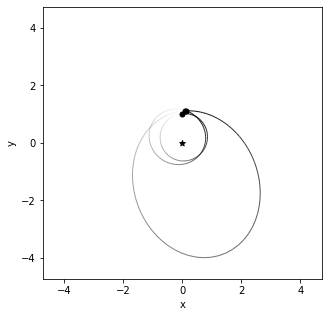

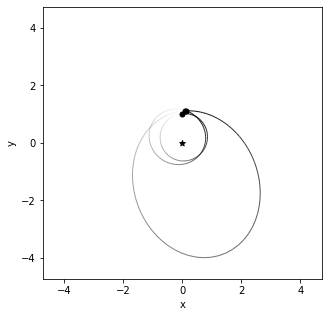

In [9]:
rebound.OrbitPlot(sim)

In [6]:
spock_3p_tseries(sim, (1e4,  10000))

../generate_training_data/training_data_functions.py:1368: RuntimeWarning: invalid value encountered in sqrt
  Lcirc += mred * np.sqrt(sim.G*(p.m + Mint)*p.a)


array([[0.00000000e+00, 1.32828278e-16, 6.64141391e-17, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00458947e+00, 6.93273950e-01, 1.65611091e-01, ...,
        3.11625041e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00917894e+00, 6.88348190e-01, 1.67633394e-01, ...,
        2.75346255e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.99802080e+03, 1.57404377e+00, 1.80558741e+00, ...,
        3.37578778e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99902539e+03, 1.57404378e+00, 1.80558742e+00, ...,
        3.38710565e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000300e+04, 1.57404378e+00, 1.80558743e+00, ...,
        3.39860924e+00, 0.00000000e+00, 0.00000000e+00]])

In [7]:
sim.collision

'line'

In [23]:
o = spock_features(sim, (1e4,  10000))
len(o)

21

In [24]:
o

EMfracstdnear                 4.161424e-05
EPstdnear                     4.912026e-05
EMfreestdnear                          NaN
AMDcritnear                   3.705557e-04
AMDfracnear                   1.388177e-07
AMDstdnear                    5.084804e-08
EMcrossnear                   2.100000e+00
MMRhalfwidthnear                       NaN
MMRstrengthnear               0.000000e+00
EMfracstdfar                  3.700051e-05
EPstdfar                      3.676705e-05
EMfreestdfar                           NaN
AMDcritfar                    7.253052e-04
AMDfracfar                    7.092143e-08
AMDstdfar                     2.597807e-08
EMcrossfar                    2.290323e+00
MMRhalfwidthfar                        NaN
MMRstrengthfar                0.000000e+00
MEGNOmed                      2.061738e+00
MEGNOstd                      2.205101e-02
unstableinshortintegration    0.000000e+00
dtype: float64

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import dill
import sys
sys.path.append('../')
sys.path.append('../generate_training_data/')
import rebound
from training_data_functions import spock_features, spock_3p_tseries
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/data/'
repopath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/'
dataset = 'resonant'
trainingdatafolder = repopath + 'training_data/' + dataset + '/'
safolder = datapath + dataset + '/simulation_archives/runs/'
runfunc = spock_features
foldername = runfunc.__name__ + 'Norbits10000.0Nout1000'
outputfolder = trainingdatafolder + foldername

In [3]:
import dask.dataframe as dd
df = pd.read_csv(outputfolder+"/runstrings.csv", index_col = 0) 
df.head()

,runstring
0,0000000.bin
1,0000001.bin
2,0000002.bin
3,0000003.bin
4,0000004.bin


In [34]:
def test(row):
    print('start' + row['runstring'])
    sa = rebound.SimulationArchive(safolder+'sa'+row['runstring'])
    f = spock_features(sa[0], (1e4, 1000))
    if f['unstableinshortintegration'] == True:
        print("{0} unstable".format(row['runstring']))
    row['unstableinshortintegration'] = f['unstableinshortintegration']
    print(f)
    return row

In [35]:
res = df.head(5).apply(test,axis=1)

start0000000.bin


/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


EMfracstdnear                 3.073820e-02
EPstdnear                     2.801152e-04
EMfreestdnear                 3.245490e-01
AMDcritnear                   3.184811e-09
AMDfracnear                   2.737852e+01
AMDstdnear                    1.818672e-02
EMcrossnear                   6.023365e-02
MMRhalfwidthnear              5.704760e-03
MMRstrengthnear               6.710844e-01
EMfracstdfar                  8.763452e-04
EPstdfar                      3.309716e-04
EMfreestdfar                           NaN
AMDcritfar                    2.034865e-06
AMDfracfar                    4.285072e-02
AMDstdfar                     2.846444e-05
EMcrossfar                    5.040627e-01
MMRhalfwidthfar                        NaN
MMRstrengthfar                         NaN
MEGNOmed                      1.999072e+00
MEGNOstd                      6.351872e-02
unstableinshortintegration    0.000000e+00
dtype: float64
start0000000.bin
EMfracstdnear                 3.073820e-02
EPstdnear             

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:98: UserWarning: k=1 resonance has no separatrix for Phiprime < 1
  warnings.warn("k=1 resonance has no separatrix for Phiprime < 1")


EMfracstdnear                 1.736515e-02
EPstdnear                     1.365705e-04
EMfreestdnear                 2.825248e-01
AMDcritnear                   1.333975e-08
AMDfracnear                   2.208342e+00
AMDstdnear                    1.671816e-02
EMcrossnear                   8.054734e-02
MMRhalfwidthnear              4.950774e-03
MMRstrengthnear               3.356036e-01
EMfracstdfar                  8.914700e-03
EPstdfar                      2.136309e-03
EMfreestdfar                           NaN
AMDcritfar                    3.742986e-08
AMDfracfar                    7.870382e-01
AMDstdfar                     5.958241e-03
EMcrossfar                    2.405043e-01
MMRhalfwidthfar                        NaN
MMRstrengthfar                7.445377e-03
MEGNOmed                      2.012131e+00
MEGNOstd                      6.883407e-02
unstableinshortintegration    0.000000e+00
dtype: float64
start0000002.bin
EMfracstdnear                 2.886713e-02
EPstdnear             

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:106: UserWarning: k=2 resonance has no separatrix for Phiprime < -2/3
  warnings.warn("k=2 resonance has no separatrix for Phiprime < -2/3")


EMfracstdnear                 0.038106
EPstdnear                     0.000929
EMfreestdnear                 2.010827
AMDcritnear                   0.000002
AMDfracnear                   0.949900
AMDstdnear                    0.002335
EMcrossnear                   0.406112
MMRhalfwidthnear              0.007696
MMRstrengthnear               0.710219
EMfracstdfar                  0.035091
EPstdfar                      0.003541
EMfreestdfar                       NaN
AMDcritfar                    0.000003
AMDfracfar                    0.692802
AMDstdfar                     0.001703
EMcrossfar                    0.427768
MMRhalfwidthfar                    NaN
MMRstrengthfar                0.009937
MEGNOmed                      2.006496
MEGNOstd                      0.065447
unstableinshortintegration    0.000000
dtype: float64
start0000004.bin
EMfracstdnear                 2.482589e-02
EPstdnear                     2.010973e-03
EMfreestdnear                 3.989288e-01
AMDcritnear         

In [4]:
def training_data(row, safolder, runfunc, args):
    try: 
        sa = rebound.SimulationArchive(safolder+'sa'+row['runstring'])
        sim = sa[0]
    except:
        print("traininst_data_functions.py Error reading " + safolder+'sa'+row['runstring'])
        return None 
    
    return runfunc(sim, args)

In [89]:
df.loc[241:242]

,runstring
241,0000241.bin
242,0000242.bin


In [5]:
args = (1e4, 1000)
sa = rebound.SimulationArchive(safolder+'sa'+df.loc[16]['runstring'])
testres = spock_features(sa[0], (1e4,1000))
metadf = pd.DataFrame([testres])
ddf = dd.from_pandas(df.loc[241:242], npartitions=24)
res = ddf.apply(training_data, meta=metadf, args=(safolder, runfunc, args), axis=1).compute(scheduler='processes')

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/work

In [75]:
res

,EMfracstdnear,EPstdnear,EMfreestdnear,AMDcritnear,AMDfracnear,AMDstdnear,EMcrossnear,MMRhalfwidthnear,MMRstrengthnear,EMfracstdfar,...,EMfreestdfar,AMDcritfar,AMDfracfar,AMDstdfar,EMcrossfar,MMRhalfwidthfar,MMRstrengthfar,MEGNOmed,MEGNOstd,unstableinshortintegration
235,0.022015,0.001943,0.803185,1.853533e-07,1.115748,0.006908,0.182538,0.005003,2.174470,0.012561,...,NaN,2.565585e-06,0.080608,0.000499,0.320542,NaN,0.042351,2.019206,0.074971,0.0
236,0.044294,0.002267,0.746791,3.887307e-07,1.009456,0.031051,0.132530,0.007861,0.180386,0.057197,...,NaN,2.650466e-06,0.148052,0.004554,0.446357,NaN,0.004270,1.942891,0.063633,0.0
237,0.143328,0.008343,4.947997,6.429060e-06,2.350586,0.018376,0.405101,0.011734,1.525384,0.160097,...,5.845523,9.287253e-06,1.627183,0.012721,0.406446,0.009933,2.803942,1.972703,0.077792,0.0
238,0.035441,0.000313,3.297127,3.006414e-07,0.057990,0.000728,0.251667,0.002705,0.149748,0.005312,...,NaN,5.940435e-07,0.029348,0.000368,0.437356,NaN,0.000181,2.109971,0.087879,0.0
239,0.054557,0.001302,3.853409,2.553467e-06,0.413174,0.000423,0.405738,0.005744,2.355986,0.020487,...,NaN,1.577030e-06,0.668996,0.000684,0.463699,NaN,NaN,2.067543,0.092649,0.0
240,0.058340,0.000225,2.155960,1.485316e-09,6.114512,0.003274,0.050628,0.001370,1.727427,0.015561,...,3.001542,1.178270e-08,0.770790,0.000413,0.182636,0.000984,0.046995,1.888054,0.193584,0.0


In [90]:
sa = rebound.SimulationArchive(safolder+'sa0000242.bin')
f = spock_features(sa[0], (1e4, 1000))
f

OrderedDict([('EMfracstdnear', nan),
             ('EPstdnear', nan),
             ('EMfreestdnear', nan),
             ('AMDcritnear', 1.344227737750811e-07),
             ('AMDfracnear', nan),
             ('AMDstdnear', nan),
             ('EMcrossnear', 0.12047399482302135),
             ('MMRhalfwidthnear', 0.00862859022003137),
             ('MMRstrengthnear', 0.09357716536492998),
             ('EMfracstdfar', nan),
             ('EPstdfar', nan),
             ('EMfreestdfar', nan),
             ('AMDcritfar', 2.9552385567169244e-05),
             ('AMDfracfar', nan),
             ('AMDstdfar', nan),
             ('EMcrossfar', 0.8562041845460466),
             ('MMRhalfwidthfar', nan),
             ('MMRstrengthfar', nan),
             ('MEGNOmed', nan),
             ('MEGNOstd', nan),
             ('unstableinshortintegration', 1.0)])

In [95]:
sa = rebound.SimulationArchive(safolder+'sa0000241.bin')
f = spock_features(sa[0], (1e4, 1000))
f

EMfracstdnear                 5.452252e-02
EPstdnear                     1.250276e-02
EMfreestdnear                 1.350579e+00
AMDcritnear                   1.656921e-05
AMDfracnear                   5.314529e-01
AMDstdnear                    4.270390e-03
EMcrossnear                   5.889372e-01
MMRhalfwidthnear              2.377524e-02
MMRstrengthnear               2.874096e+00
EMfracstdfar                  1.764834e-01
EPstdfar                      2.215182e-02
EMfreestdfar                  3.147070e+00
AMDcritfar                    1.351152e-07
AMDfracfar                    6.517223e+01
AMDstdfar                     5.236792e-01
EMcrossfar                    5.949082e-01
MMRhalfwidthfar               1.020325e-02
MMRstrengthfar                8.942243e-01
MEGNOmed                      1.481503e+00
MEGNOstd                      6.133718e-01
unstableinshortintegration    0.000000e+00
dtype: float64

In [94]:
len(f)

21

In [91]:
keys1 = [key for (key,val) in f.items()]

In [92]:
sa = rebound.SimulationArchive(safolder+'sa0000000.bin')
f = spock_features(sa[0], (1e4, 1000))
keys2 = [key for (key,val) in f.items()]

In [93]:
np.sum([keys1[i]==keys2[i] for i in range(len(keys1))])

21

In [8]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 50),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 100,
                            max_depth = params['max_depth'], 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            learning_rate = params['learning_rate'], seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [106]:
Norbits = 1e4

AMD = ['AMDfracnear', 'AMDfracfar', 'AMDstdnear', 'AMDstdfar']
megno = ['MEGNOmed', 'MEGNOstd'] # 'tlyap'


resparamfeatures = ['EMcrossnear', 'EMcrossfar', 'MMRhalfwidthnear', 'MMRstrengthnear']#, 'strengthnear', 'secondres']

tseriesshort = ['EPstdnear', 'EPstdfar', 'EMfreenear', 'EMfracstdnear', 'EMfracstdfar']

features = AMD + tseriesshort + megno + resparamfeatures 

datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'

featurefolder = 'spock_featuresNorbits{0:.1f}Nout1000/'.format(Norbits)
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [107]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.926534                                            
ERROR                                               
0.005156838926726892                                
SCORE:                                                                        
0.5                                                                           
ERROR                                                                         
0.0                                                                           
SCORE:                                                                        
0.9229788600000001                                                            
ERROR                                                                         
0.003908817936080048                                                          
SCORE:                                                                        
0.9189498200000001                                                           

SCORE:                                                                         
0.92561242                                                                     
ERROR                                                                          
0.004370339298009422                                                           
SCORE:                                                                         
0.92649904                                                                     
ERROR                                                                          
0.004779109597441105                                                           
SCORE:                                                                         
0.92394252                                                                     
ERROR                                                                          
0.004194702832284085                                                           
SCORE:                                  

In [112]:
dill.dump([model, features, featurefolder], open(datapath+"../models/spock_resonant.pkl", "wb"))

In [108]:
best

{'x_learning_rate': 0.1628921025358661,
 'x_max_depth': 15,
 'x_min_child': 8.0,
 'x_pos_weight': 7.090653117113843,
 'x_subsample': 0.8942501150272054,
 'x_tree_colsample': 0.9245729027587096}

# Would have to set num_boost_round=100 to see the same CV score as in our final fitted model

We're setting n_estimators=100 in model, which is the equivalent of num_boost_round in CV, so if we use the default in CV (10), we will get slightly lower powerformance

In [109]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.952095+0.00196646	test-auc:0.899573+0.00315556
[1]	train-auc:0.967083+0.00131623	test-auc:0.913829+0.0021944
[2]	train-auc:0.975211+0.000186566	test-auc:0.921286+0.00298305
[3]	train-auc:0.97923+0.000648336	test-auc:0.924991+0.00360046
[4]	train-auc:0.982113+0.000795495	test-auc:0.927669+0.0029624
[5]	train-auc:0.984486+0.000460643	test-auc:0.930426+0.0028413
[6]	train-auc:0.986131+0.000407196	test-auc:0.931914+0.00286847
[7]	train-auc:0.987434+0.000479684	test-auc:0.933071+0.00281428
[8]	train-auc:0.988727+0.000406222	test-auc:0.934111+0.00328109
[9]	train-auc:0.989645+0.000383082	test-auc:0.935164+0.00362775


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.9245729027587096, gamma=0,
              learning_rate=0.1628921025358661, max_delta_step=0, max_depth=15,
              min_child_weight=8.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.090653117113843,
              seed=None, silent=True, subsample=0.8942501150272054)

# All features

Text(0.5, 1.0, 'ROC curve (AUC = 0.958)')

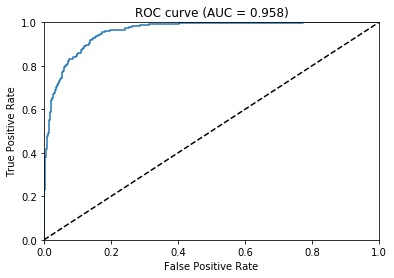

In [468]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

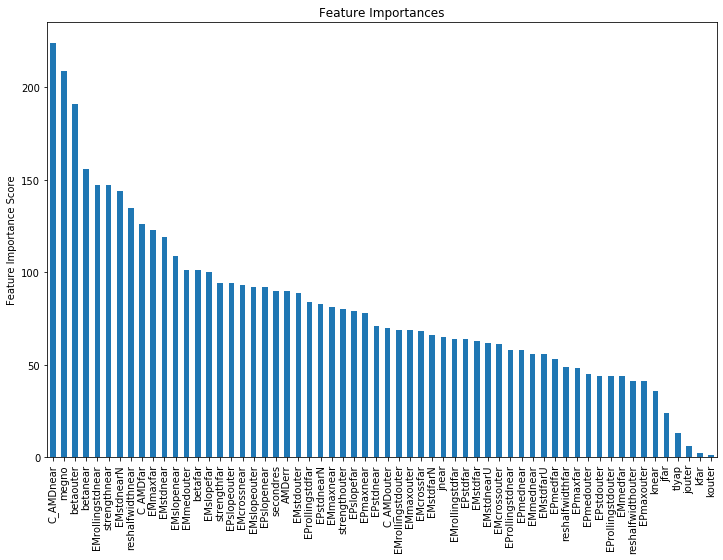

In [469]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# SPOCK

Text(0.5, 1.0, 'ROC curve (AUC = 0.952)')

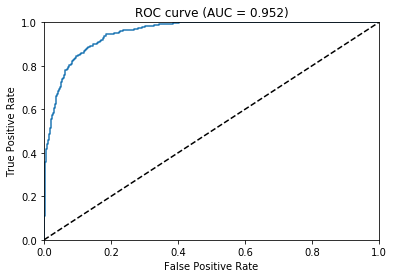

In [110]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'ROC curve (AUC = 0.949)')

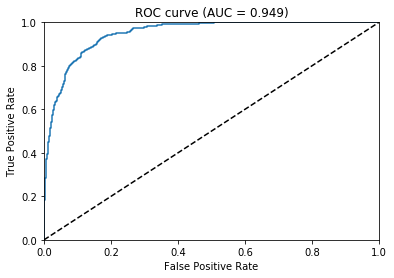

In [94]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'ROC curve (AUC = 0.949)')

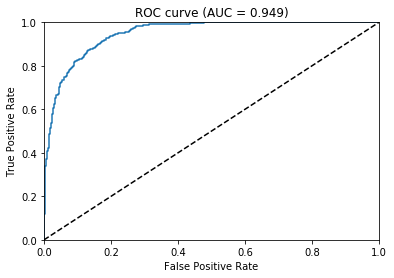

In [81]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'ROC curve (AUC = 0.945)')

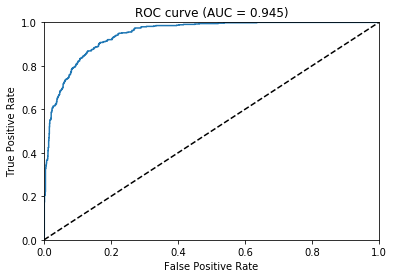

In [75]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'ROC curve (AUC = 0.951)')

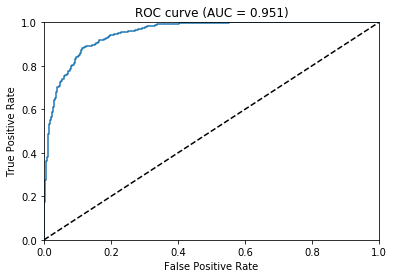

In [34]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'ROC curve (AUC = 0.951)')

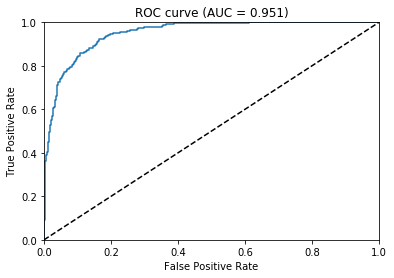

In [40]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

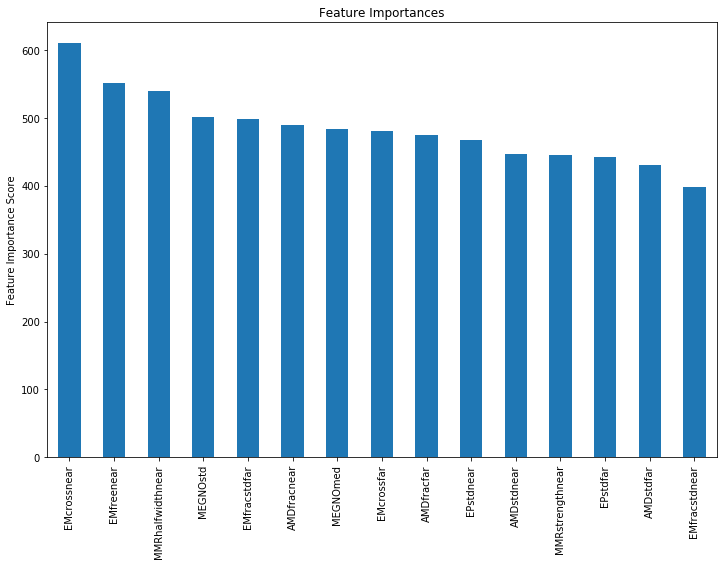

In [111]:
# fe`c`vature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

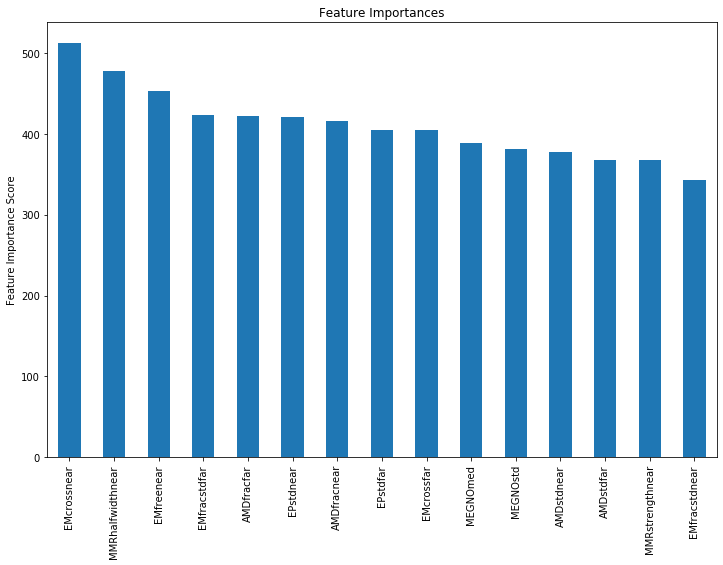

In [82]:
# fe`c`vature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

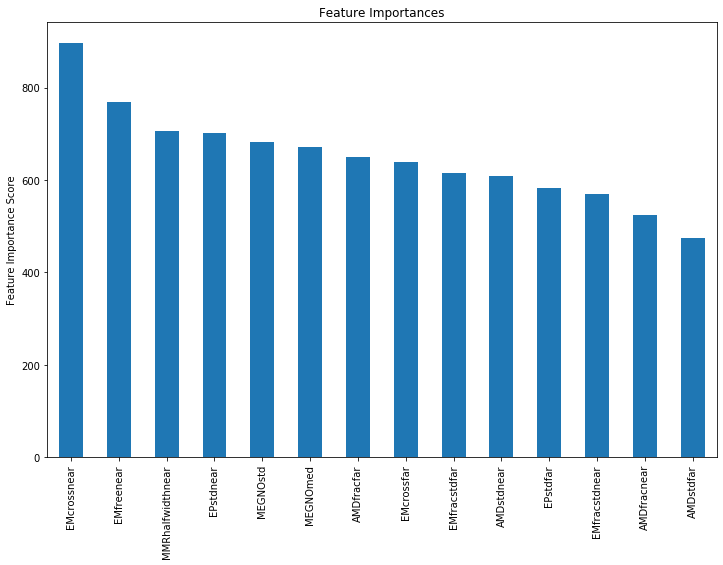

In [88]:
# fe`c`vature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

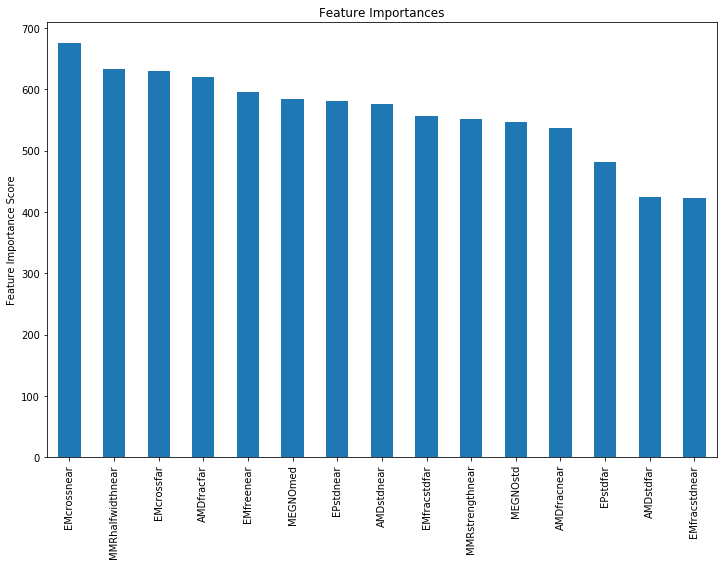

In [61]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

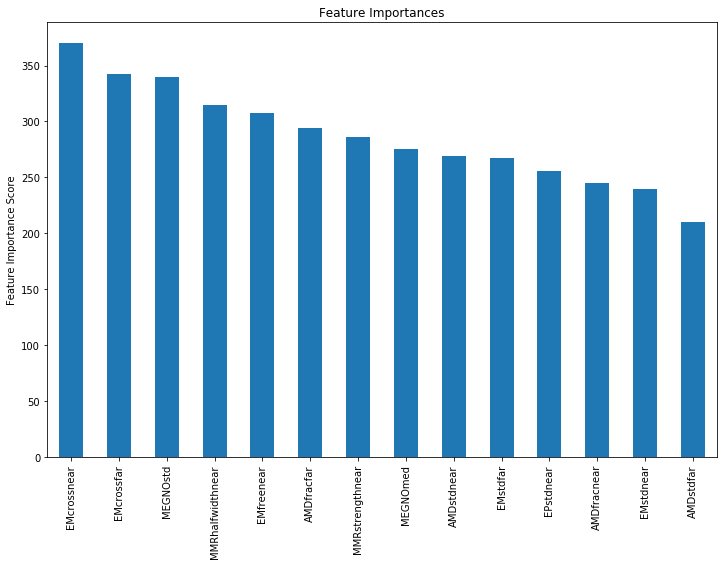

In [47]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

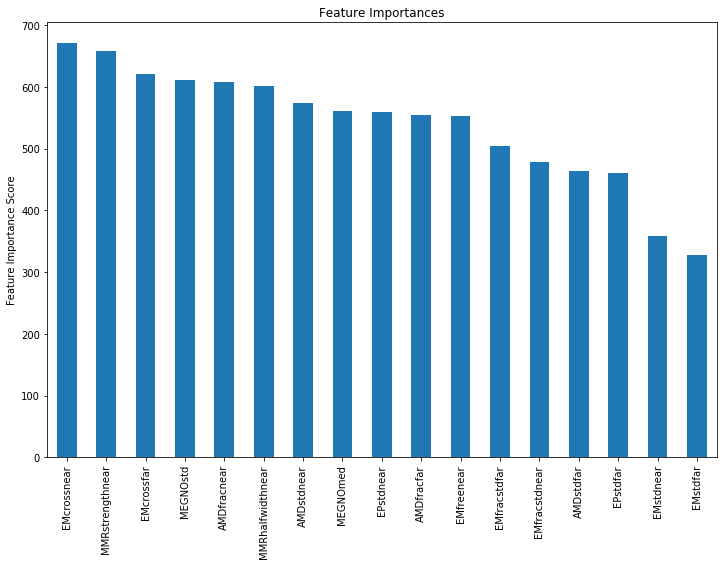

In [55]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

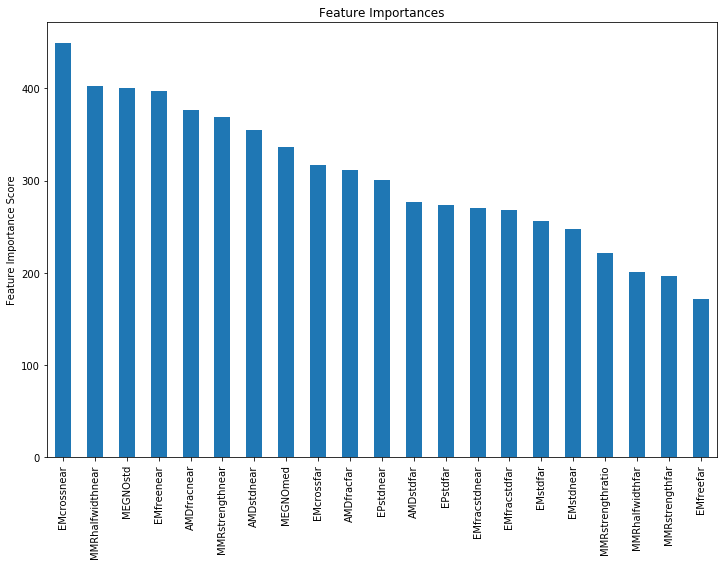

In [35]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

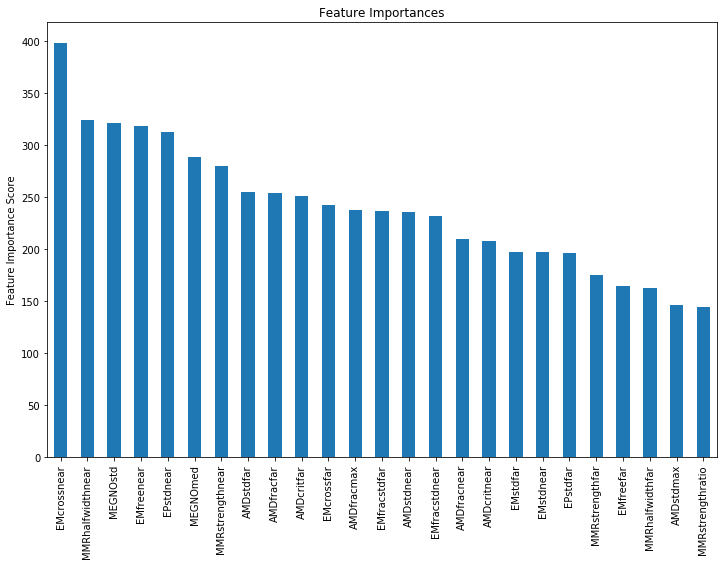

In [24]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# 9 trimmed features

Adding EMstdnearN (EMstd normalized by rehalfwidthnear) in addition to EMstdnear (normaalized to EMcrossnear) and removing reshalfwidthnear gives almost same performance.

Text(0.5, 1.0, 'ROC curve (AUC = 0.942)')

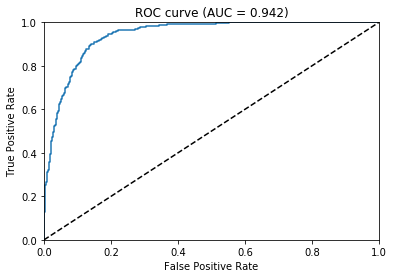

In [27]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

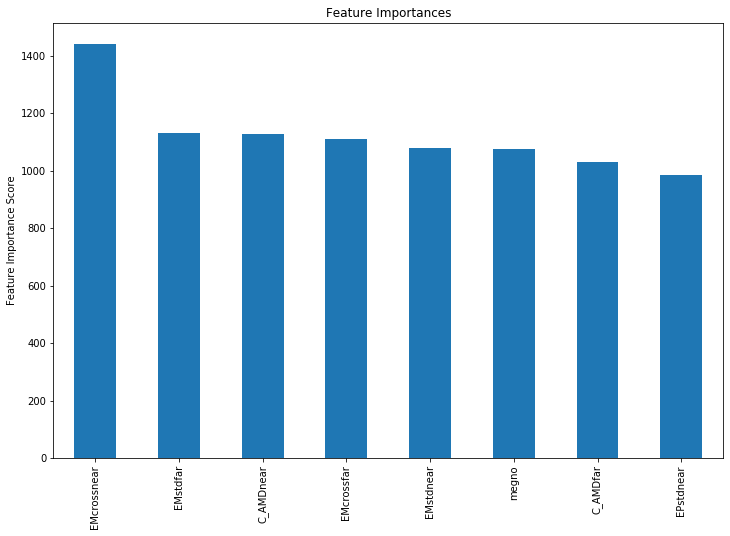

In [28]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# 11 trimmed features

Adding back strengthnear and secondres. Not sure if it's aa problem that strength isn't normalized to anything physical?

Text(0.5, 1.0, 'ROC curve (AUC = 0.948)')

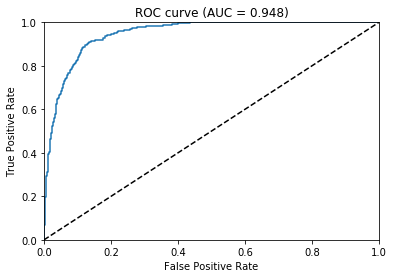

In [449]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

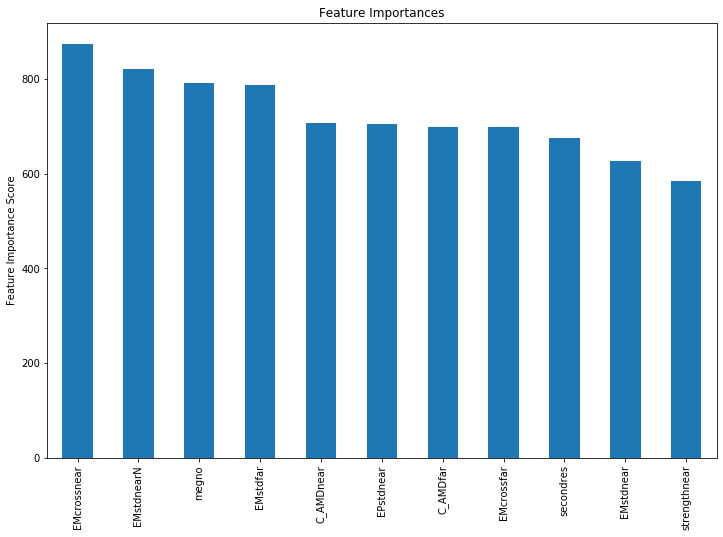

In [448]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [23]:
for i in range(0,len(fpr), 15):
    print("Threshold {0}, FPR = {1}, TPR = {2}".format(rocthresholds[i], fpr[i], tpr[i]))

Threshold 1.9999017715454102, FPR = 0.0, TPR = 0.0
Threshold 0.9860304594039917, FPR = 0.00411240575736806, TPR = 0.3844731977818854
Threshold 0.9591091871261597, FPR = 0.01028101439342015, TPR = 0.512014787430684
Threshold 0.9424808025360107, FPR = 0.018505825908156272, TPR = 0.5582255083179297
Threshold 0.9128478765487671, FPR = 0.025359835503769704, TPR = 0.6284658040665434
Threshold 0.8827143907546997, FPR = 0.033584647018505824, TPR = 0.6691312384473198
Threshold 0.8439748883247375, FPR = 0.03906785469499657, TPR = 0.7079482439926063
Threshold 0.8000836372375488, FPR = 0.04934886908841672, TPR = 0.7264325323475046
Threshold 0.7116411328315735, FPR = 0.06442769019876628, TPR = 0.7837338262476895
Threshold 0.6079264283180237, FPR = 0.07539410555174778, TPR = 0.8133086876155268
Threshold 0.5018351078033447, FPR = 0.08978752570253598, TPR = 0.8373382624768947
Threshold 0.4287303388118744, FPR = 0.10212474297464016, TPR = 0.8539741219963032
Threshold 0.3341927230358124, FPR = 0.1151473

In [100]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.0025387408677488565, recall = 1.0, precision = 0.43876723438767234
Threshold 0.002793877152726054, recall = 0.9981515711645101, precision = 0.4433497536945813
Threshold 0.0033131123054772615, recall = 0.9981515711645101, precision = 0.4488778054862843
Threshold 0.0036996505223214626, recall = 0.9981515711645101, precision = 0.45454545454545453
Threshold 0.004002034198492765, recall = 0.9981515711645101, precision = 0.46035805626598464
Threshold 0.004368775989860296, recall = 0.9981515711645101, precision = 0.46632124352331605
Threshold 0.005086724646389484, recall = 0.9981515711645101, precision = 0.47244094488188976
Threshold 0.005759655963629484, recall = 0.9963031423290203, precision = 0.4778368794326241
Threshold 0.0063275182619690895, recall = 0.9944547134935305, precision = 0.4833782569631626
Threshold 0.006997937336564064, recall = 0.9944547134935305, precision = 0.4899817850637523
Threshold 0.007695464417338371, recall = 0.9944547134935305, precision = 0.49676823638

In [55]:
i=400
PRthreshold = PRthresholds[i]
rec = recall[i]
prec = precision[i]
print(PRthreshold, rec, prec)

0.06322314 0.9704251386321626 0.6302521008403361


In [86]:
trainX, trainy, testX, testy = train_test_split(trainingdatafolder, features, filter=False)
preds = model.predict_proba(testX)[:,1]

In [87]:
predy = (preds >= PRthreshold)

In [88]:
predlabels[:10]

array([False, False, False, False, False, False, False, False,  True,
        True])

In [89]:
testy[:10]

7999     True
8000    False
8001    False
8002    False
8003     True
8004    False
8005    False
8006     True
8007    False
8008    False
Name: Stable, dtype: bool

In [120]:
np.linspace(0,1,N)

array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
       0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
       0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
       0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
       0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
       0.07007007, 0.07107107, 0.07207207, 0.07307307, 0.07407

In [126]:
predy = (preds >= 0)
tn, fp, fn, tp = confusion_matrix(testy, predy).ravel()
tn, fp, fn, tp

(0, 1459, 0, 541)

In [128]:
npv[np.isnan(npv)] = 1

In [130]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc

N=1000
npv, tnr = np.zeros(N), np.zeros(N)
ppv, tpr = np.zeros(N), np.zeros(N)
for i, thresh in enumerate(np.linspace(0, 1, N)):
    predy = (preds >= thresh)
    tn, fp, fn, tp = confusion_matrix(testy, predy).ravel()
    ppv[i] = tp/(tp+fp)
    tpr[i] = tp/(tp+fn)
    npv[i] = tn/(tn+fn)
    tnr[i] = tn/(tn+fp)
    
# When thresh is 0 or 1, we don't predict any of one class, so ppv and npv can be nan (conditioned on predicted pos or neg)
ppv[np.isnan(ppv)] = 1
npv[np.isnan(npv)] = 1
#tpr[np.isnan(tpr)] = 1
#tnr[np.isnan(tnr)] = 1

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [91]:
pp = tp+fp
pp

833

In [92]:
prec = tp/pp
prec

0.6302521008403361

In [93]:
p = tp+fn
rec = tp/p
rec

0.9704251386321626

In [116]:
for i in range(0,len(rec), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], rec[i], prec[i]))

Threshold 0.0025387408677488565, recall = 1.0, precision = 0.43876723438767234
Threshold 0.002793877152726054, recall = 0.9981515711645101, precision = 0.4433497536945813
Threshold 0.0033131123054772615, recall = 0.9981515711645101, precision = 0.4488778054862843
Threshold 0.0036996505223214626, recall = 0.9981515711645101, precision = 0.45454545454545453
Threshold 0.004002034198492765, recall = 0.9981515711645101, precision = 0.46035805626598464
Threshold 0.004368775989860296, recall = 0.9981515711645101, precision = 0.46632124352331605
Threshold 0.005086724646389484, recall = 0.9981515711645101, precision = 0.47244094488188976
Threshold 0.005759655963629484, recall = 0.9963031423290203, precision = 0.4778368794326241
Threshold 0.0063275182619690895, recall = 0.9944547134935305, precision = 0.4833782569631626
Threshold 0.006997937336564064, recall = 0.9944547134935305, precision = 0.4899817850637523
Threshold 0.007695464417338371, recall = 0.9944547134935305, precision = 0.49676823638

IndexError: index 1245 is out of bounds for axis 0 with size 1232

In [118]:
for i in range(0,len(rec), 15):
    print("Threshold {0}, tnr = {1}, npv = {2}".format(PRthresholds[i], tnr[i], npv[i]))

Threshold 0.0025387408677488565, tnr = 0.5257025359835503, npv = 1.0
Threshold 0.002793877152726054, tnr = 0.5352981494174092, npv = 0.9987212276214834
Threshold 0.0033131123054772615, tnr = 0.5455791638108294, npv = 0.998745294855709
Threshold 0.0036996505223214626, tnr = 0.5558601782042495, npv = 0.9987684729064039
Threshold 0.004002034198492765, tnr = 0.5661411925976696, npv = 0.9987908101571947
Threshold 0.004368775989860296, tnr = 0.5764222069910898, npv = 0.998812351543943
Threshold 0.005086724646389484, tnr = 0.5867032213845099, npv = 0.9988331388564761
Threshold 0.005759655963629484, tnr = 0.5962988348183688, npv = 0.9977064220183486
Threshold 0.0063275182619690895, tnr = 0.6058944482522276, npv = 0.9966178128523112
Threshold 0.006997937336564064, tnr = 0.6161754626456477, npv = 0.9966740576496674
Threshold 0.007695464417338371, tnr = 0.6264564770390678, npv = 0.9967284623773174
Threshold 0.008507847785949707, tnr = 0.636737491432488, npv = 0.9967811158798283
Threshold 0.009628

IndexError: index 1245 is out of bounds for axis 0 with size 1232

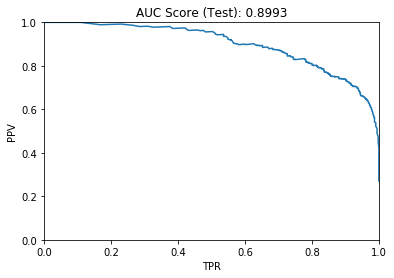

In [134]:
pr_auc = auc(tpr, ppv)
fig, ax = plt.subplots()
ax.plot(tpr, ppv)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('TPR')
ax.set_ylabel('PPV')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

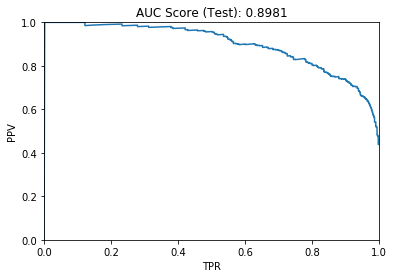

In [107]:
pr_auc = auc(tpr, ppv)
fig, ax = plt.subplots()
ax.plot(tpr, ppv)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('TPR')
ax.set_ylabel('PPV')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

In [115]:
tpr.shape

(1999,)

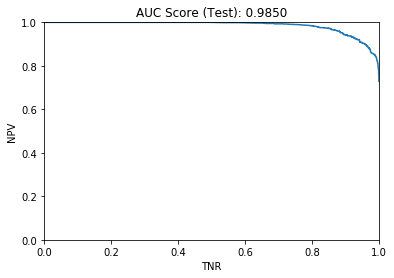

In [135]:
nauc = auc(tnr, npv)
fig, ax = plt.subplots()
ax.plot(tnr, npv)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('TNR')
ax.set_ylabel('NPV')
ax.set_title("AUC Score (Test): {0:.4f}".format(nauc))
plt.show()

(0, 216.70000000000002)

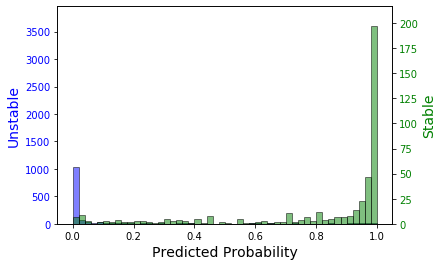

In [470]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,20.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

# 9 feat

(0, 114.4)

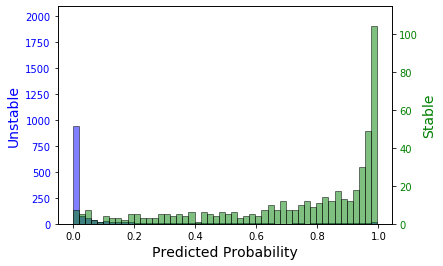

In [480]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,20.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

(0, 287.1)

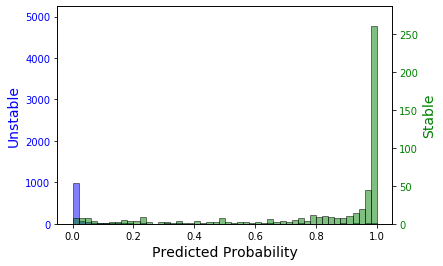

In [97]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,20.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

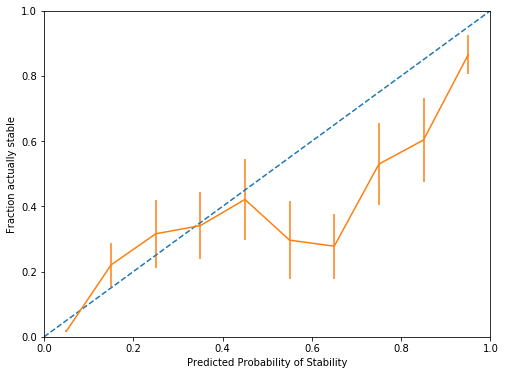

In [471]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

# 9 feat

Text(0, 0.5, 'Fraction actually stable')

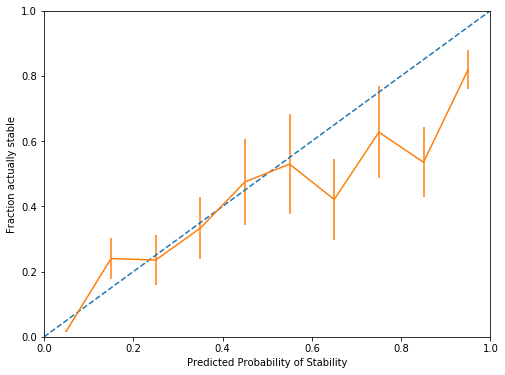

In [29]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0, 0.5, 'Fraction actually stable')

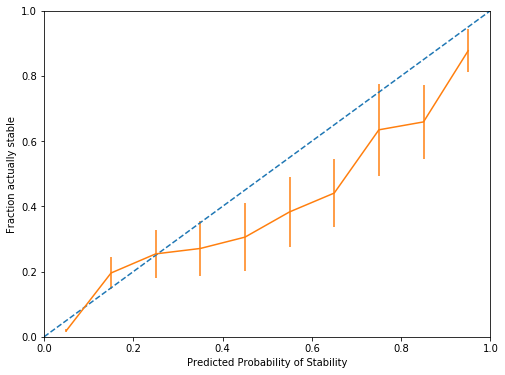

In [114]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

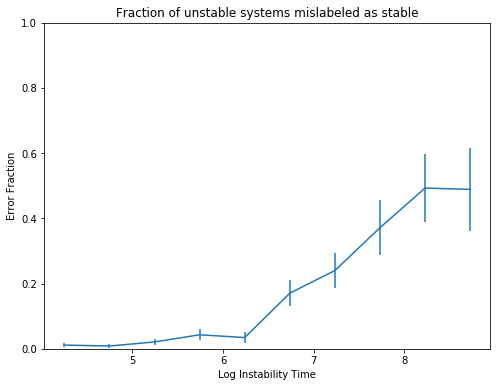

In [472]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

# 9 feat

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

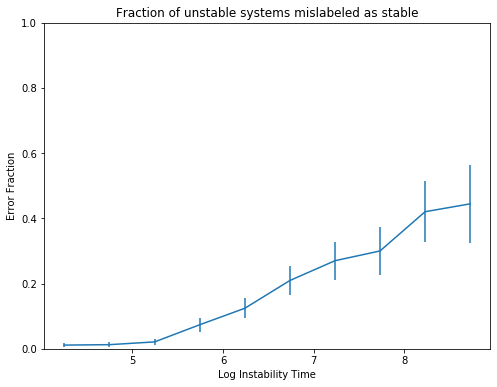

In [30]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

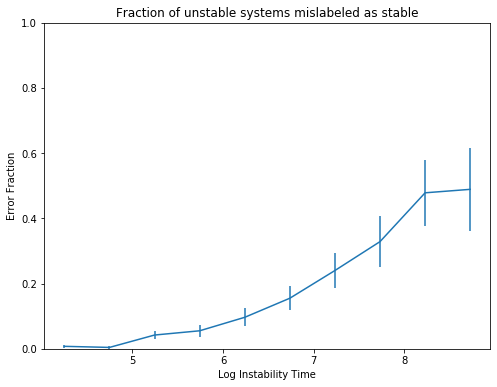

In [96]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

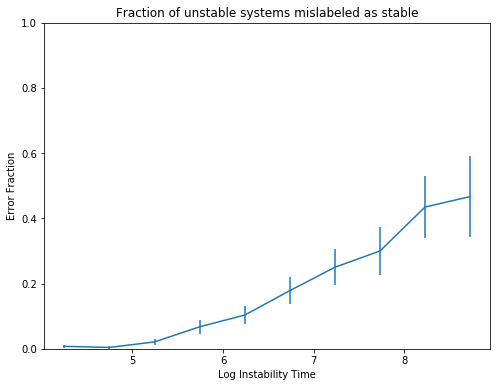

In [113]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

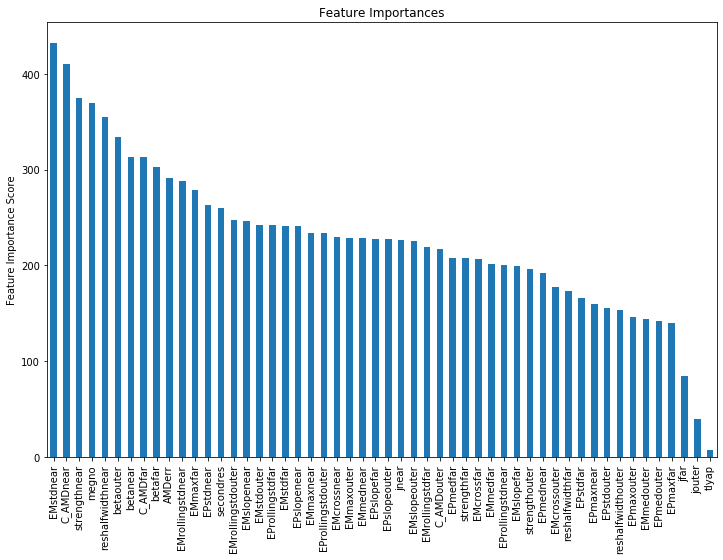

In [13]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# resparamfeatures = ['EMcrossnear', 'EMcrossfar', 'EMcrossouter', 'betanear', 'jnear', 'strengthnear', 'strengthouter', 'reshalfwidthnear', 'betafar', 'jfar', 'strengthfar', 'reshalfwidthfar', 'betaouter', 'secondres', 'reshalfwidthouter', 'jouter']

tseriesshort = ['EMcrossnear', 'EMcrossfar', 'EMstdnear', 'EMstdfar', 'EPstdnear']

ROC AUC = 0.958

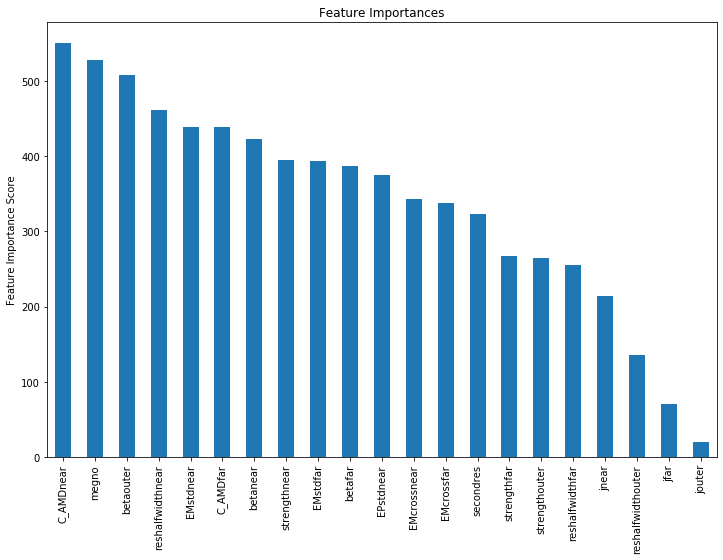

In [165]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# resparamfeatures = ['EMcrossnear', 'EMcrossfar', 'betanear', 'strengthnear', 'reshalfwidthnear', 'betafar',
                   'strengthfar', 'reshalfwidthfar', 'secondres']

tseriesshort = ['EMstdnear', 'EMstdfar', 'EPstdnear']

i.e. remove all outer features and j

ROC AUC = 0.951

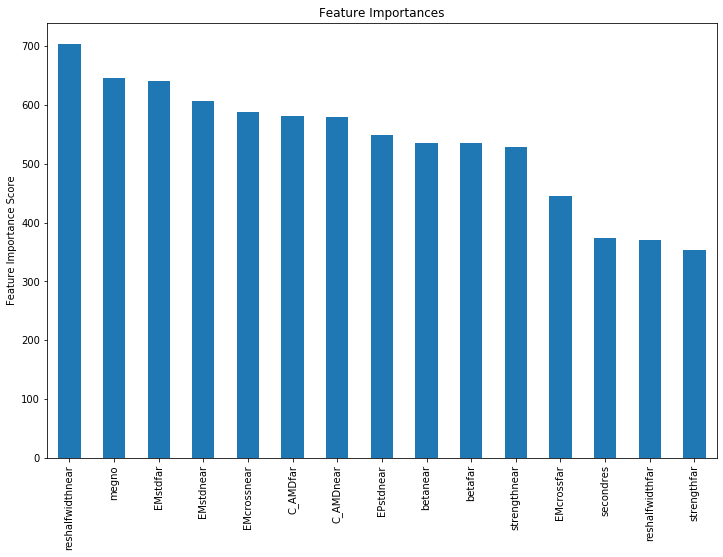

In [173]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# No resparams

ROC AUC = 0.951

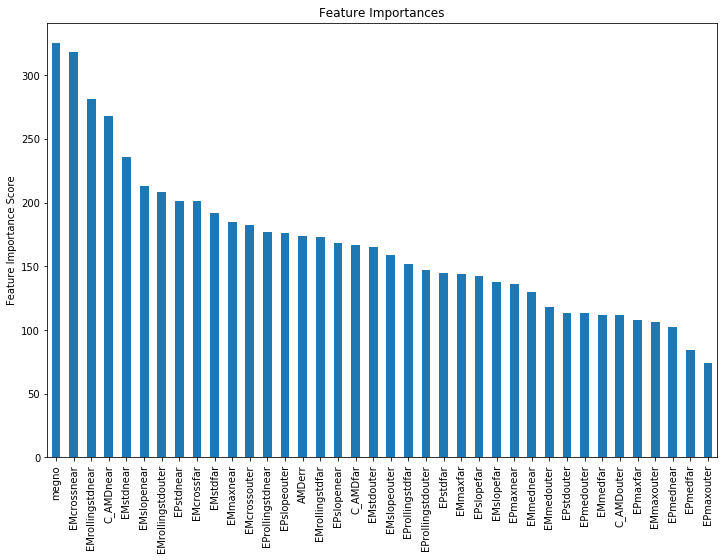

In [119]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# No respRarams tseriesshort = ['EMcrossnear', 'EMcrossfar', 'EMstdnear', 'EMstdfar', 'EPstdnear', 'EMrollingstdnear', 'EProllingstdnear']

ROC AUC = 0.946

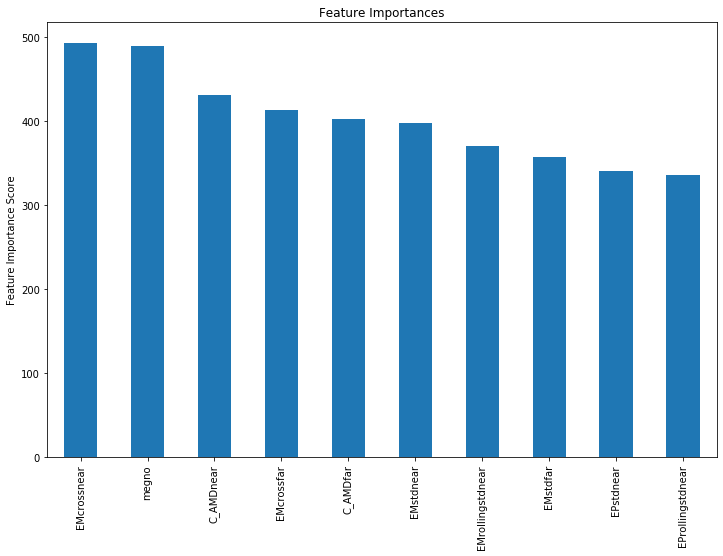

In [146]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

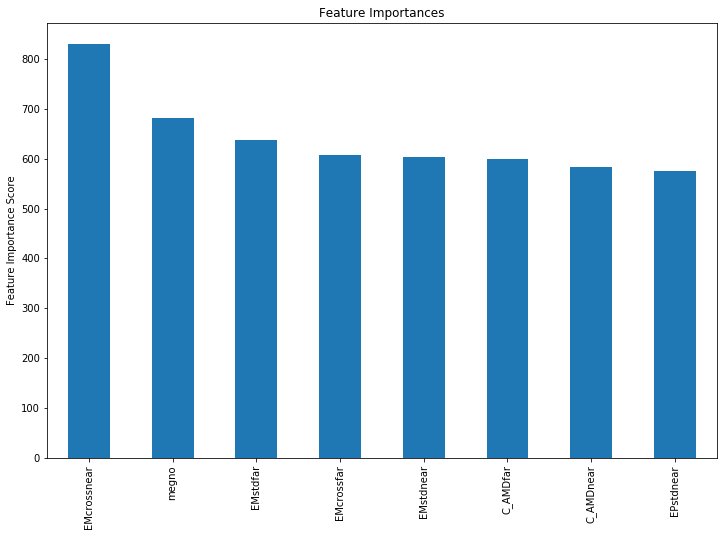

In [154]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

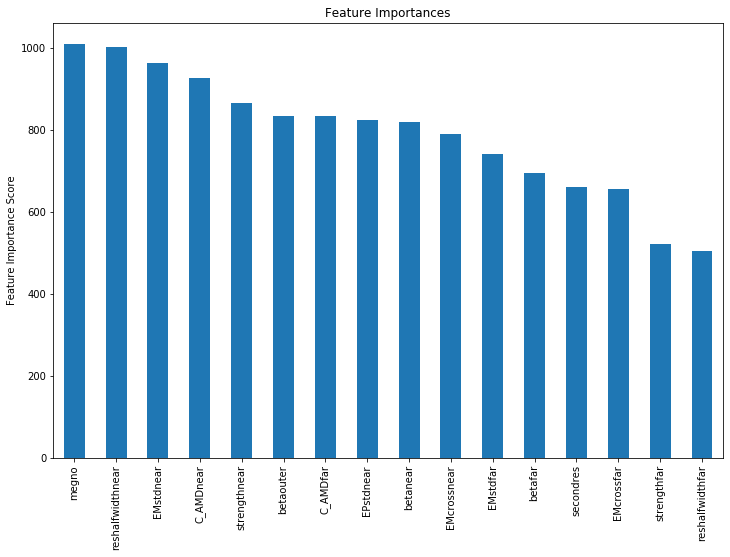

In [179]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# No resparams, tseriesshort = ['EMcrossnear', 'EMcrossfar', 'EMstdnear', 'EPstdnear']

ROC AUC = 0.942

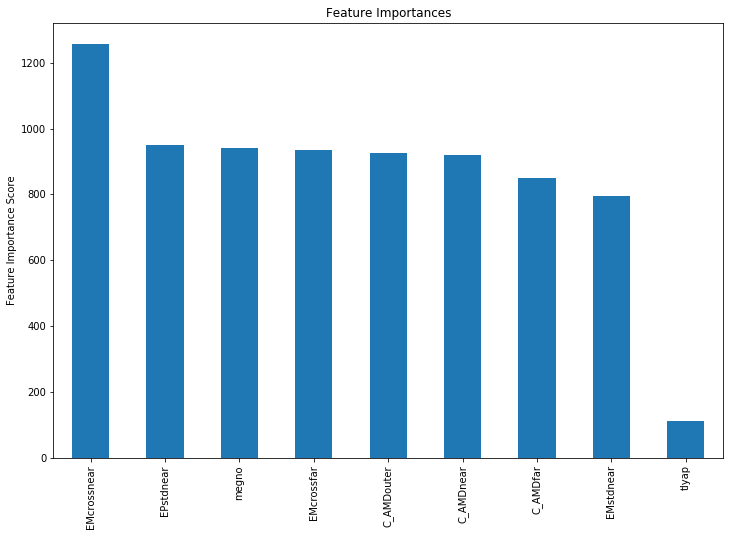

In [101]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# No resparams tseriesshort = ['EMcrossnear', 'EMcrossfar', 'EMcrossouter', 'EMstdnear', 'EMstdfar', 'EMstdouter', 'EPstdnear', 'EPstdfar', 'EPstdouter', 'EMrollingstdnear', 'EProllingstdnear'] 

ROC AUC = 0.950

so as good as full restseries (which got 0.951)

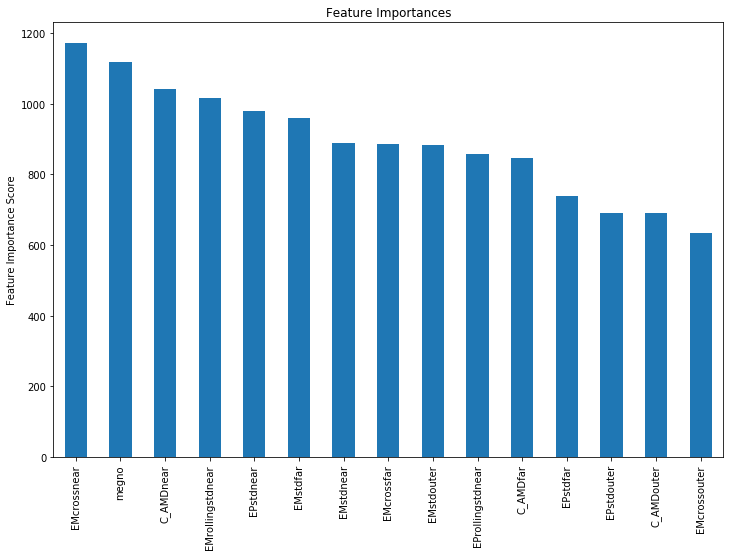

In [107]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# No resparams tseriesshort = ['EMcrossnear', 'EMcrossfar', 'EMstdnear', 'EMstdfar', 'EPstdnear', 'EPstdfar', 'EMrollingstdnear', 'EProllingstdnear']

i.e. no outer features

ROC AUC = 0.948

So outer features don't help much

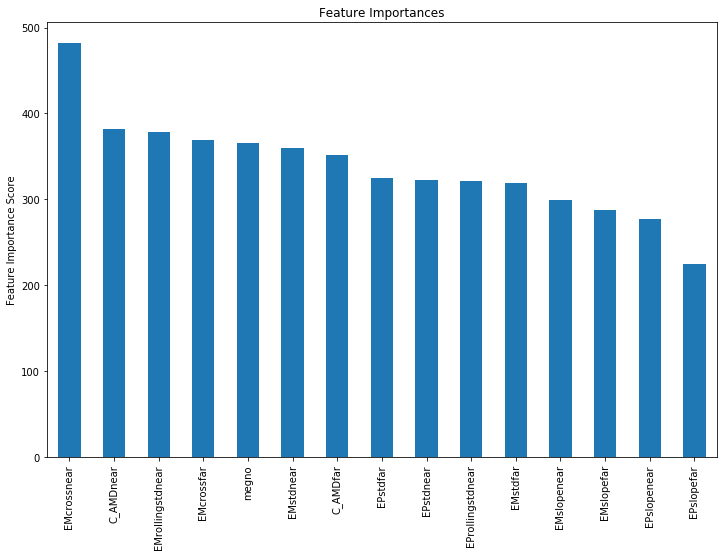

In [138]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# No resparams tseriesshort = ['EMslopenear', 'EMslopefar', 'EPslopenear', 'EPslopefar', 'EMcrossnear', 'EMcrossfar', 'EMstdnear', 'EMstdfar', 'EPstdnear', 'EPstdfar', 'EMrollingstdnear', 'EProllingstdnear']
i.e. adding slope features

ROC AUC = 0.948

so didn't help


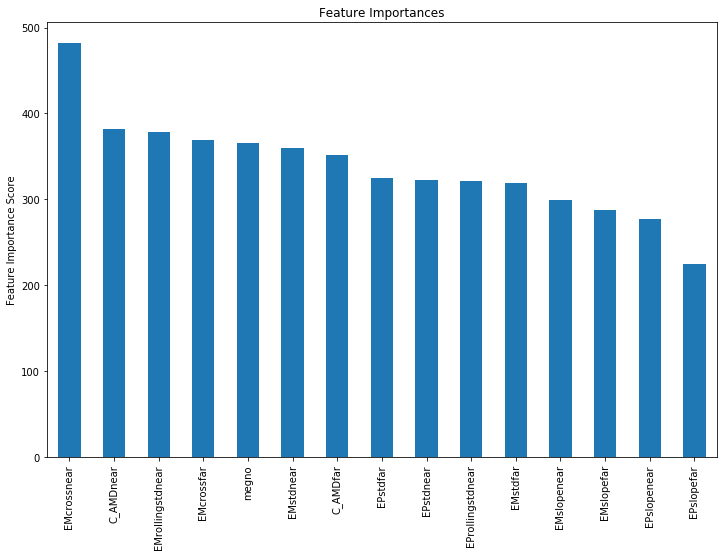

In [139]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# things that are just unstable might be very similar to things that are just stable

# predict at half a billion, then repredict at half a billion whether you'll be unstable at a billion

# do the summary features change with time?

# We care about probability it is unstable when we predict unstable. Look at these errors specifically